# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Methology

This notebook has two parts. In part one I'll go through each step seperately using some of the sample images provided.
In part two, I'll create a pipeline to handle a video stream. I'll test it on all sample images before using it on the video.

---

# PART I


## Computing the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt5
import time

In [2]:
# Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Applying distortion correction

In [3]:
import pickle
%matplotlib inline

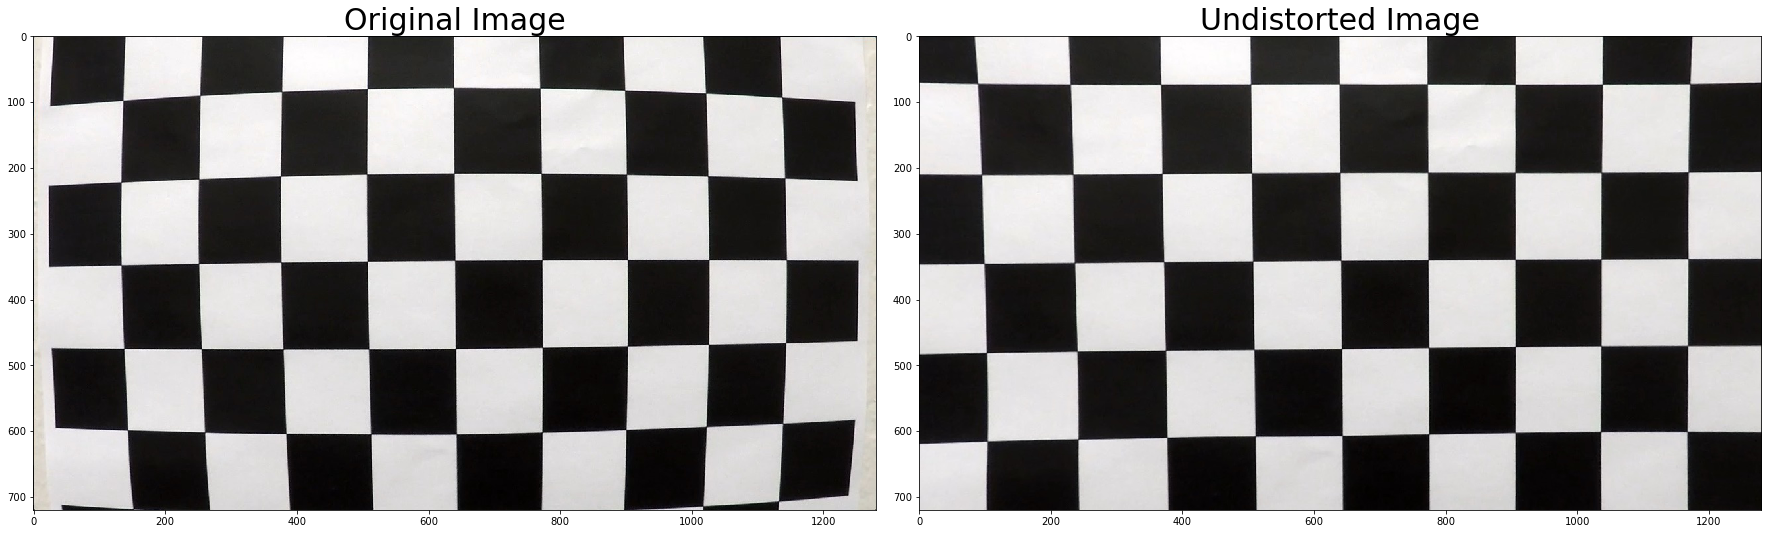

In [4]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./example_images/Chess_dist_undist.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

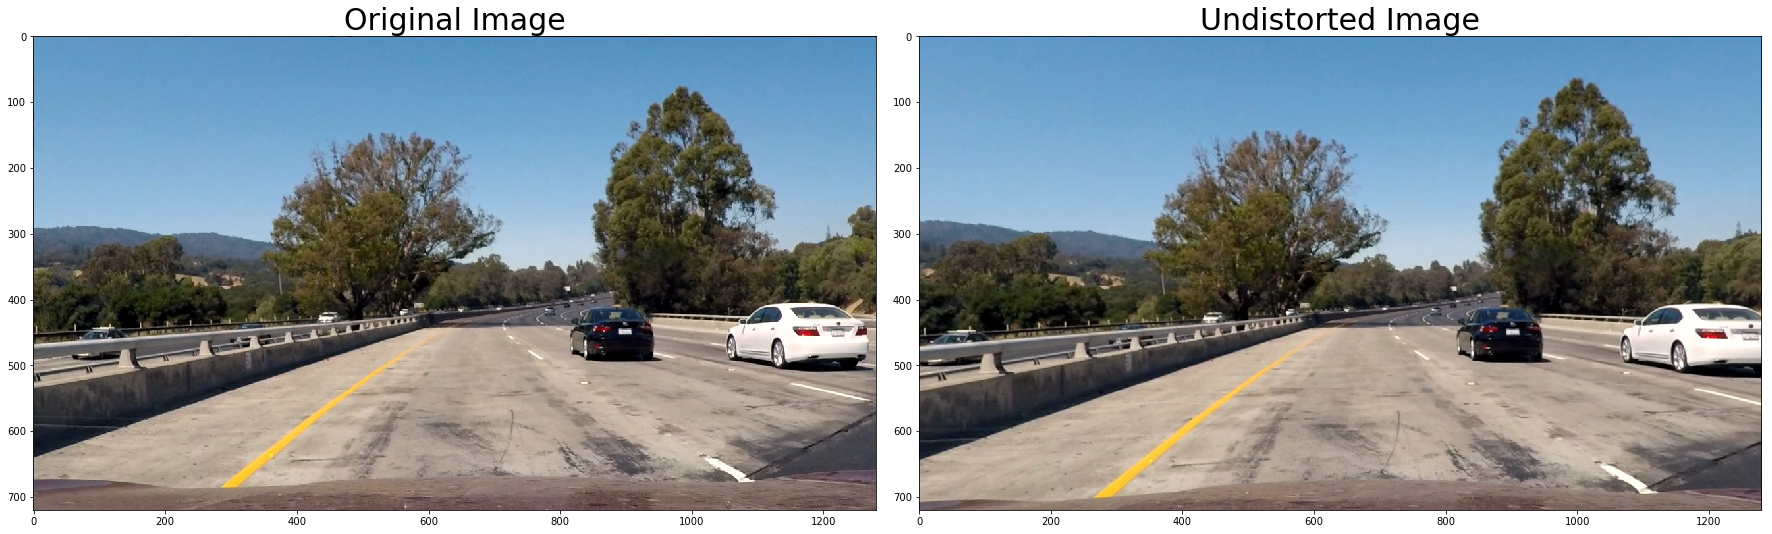

In [5]:
# For further use, we'll just import the pickle data
calibration_data = pickle.load(open('camera_calibration.p', 'rb'))
mtx = calibration_data['mtx']
dist = calibration_data['dist']

# Test on one of the test images
img = cv2.imread('./test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./example_images/RL_dist_undist.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# Define function to undistort
def undistort_image(img):
    calibration_data = pickle.load(open('camera_calibration.p', 'rb'))
    mtx = calibration_data['mtx']
    dist = calibration_data['dist']
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

## Creating thresholded binary image

In [7]:
# Defining functions to apply to the image

# Directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# Gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    scaled_sobel = (gradmag/scale_factor).astype(np.uint8) 
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

# Gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

# HLS "S" channel threshold
def hls_s_threshold(img, thresh=(90,255)):
    # Get S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    S = hls[:,:,2] #L = hls[:,:,1] #H = hls[:,:,0]
    # Apply threshold
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

# HLS "H" channel threshold
def hls_h_threshold(img, thresh=(0,90)):
    # Get H channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    H = hls[:,:,0] #L = hls[:,:,1] #S = hls[:,:,2]
    # Apply threshold
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

# Color threshold
def color_threshold(img):
    # HSV transform
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Set lower and upper bounds for yellow and white
    yellow_low = np.array([0,70,80])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    # Create masks
    mask_yellow = cv2.inRange(hsv, yellow_low, yellow_high)
    mask_white = cv2.inRange(hsv, white_low, white_high)
    # Apply Gaussian Blurr
    # needed this before I integrated hist_equ_color
    mask_white = cv2.GaussianBlur(mask_white,(3,3),0)
    # Combine masks and make binary
    combined_color_thrsh = np.zeros_like(mask_yellow)
    combined_color_thrsh[(mask_yellow > 0) | (mask_white > 0)] = 1
    return combined_color_thrsh

# hist equalize color
def hist_equ_col(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    # Choose a Sobel kernel size
    return image

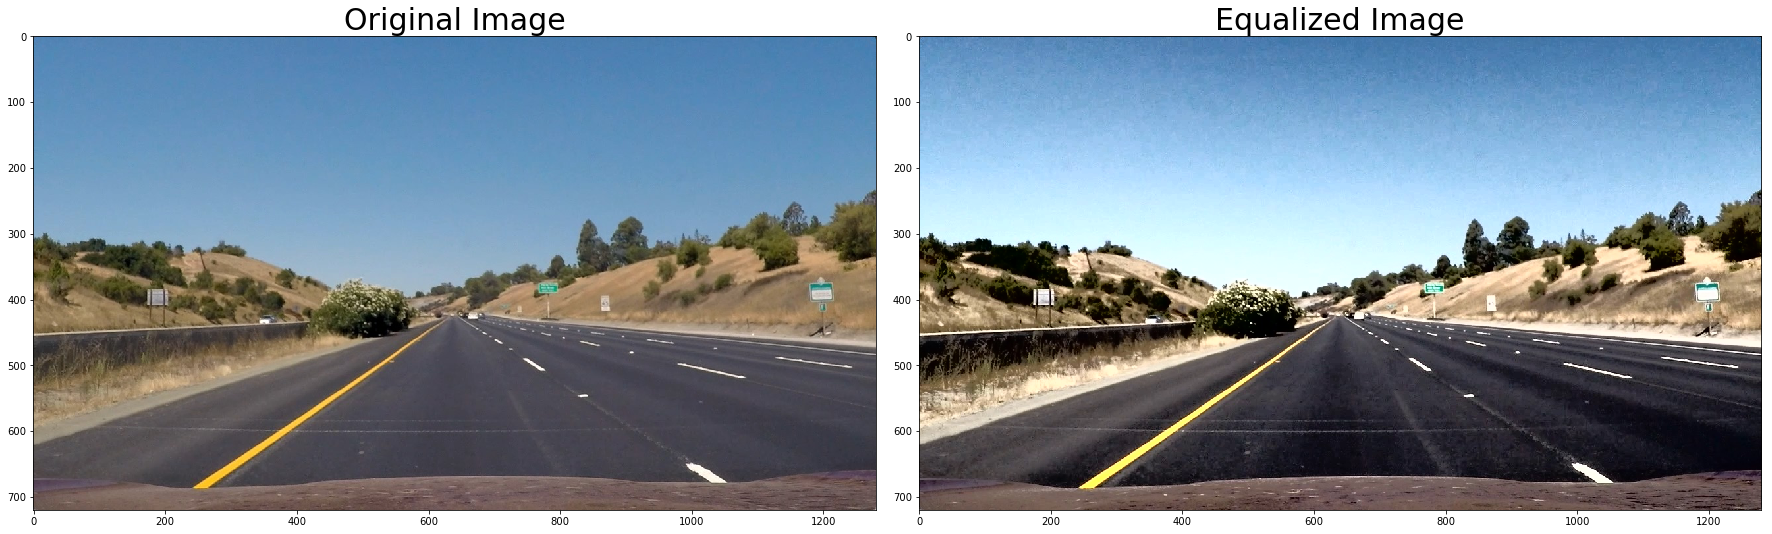

In [8]:
# Showing hist Equalized
image = cv2.imread('./test_images/straight_lines1.jpg')
hist_equalized_image = hist_equ_col(image)

# Visualize combined binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(hist_equalized_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized Image', fontsize=30)
plt.savefig('./example_images/HIst_Equalized.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

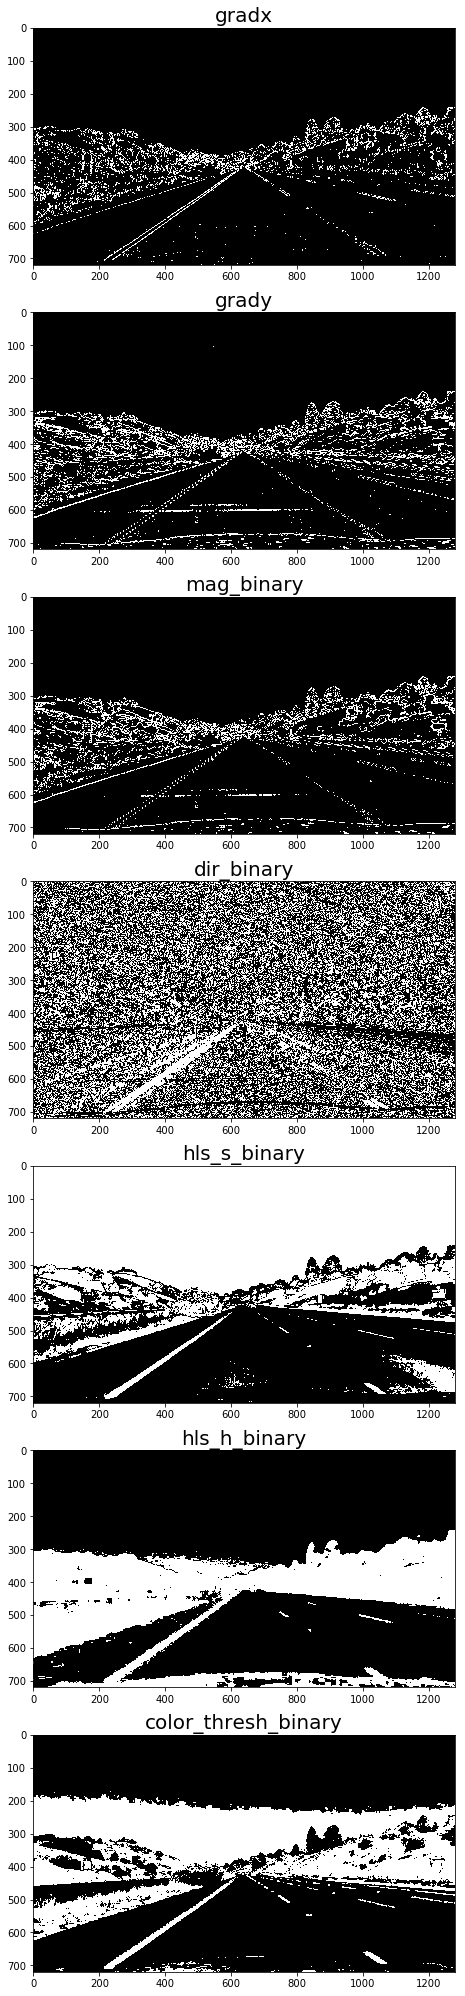

In [9]:
# Exploring based on test image
image = cv2.imread('./test_images/straight_lines1.jpg')

# Undistort test image
image = undistort_image(image)
hist_equalized_image = hist_equ_col(image)

ksize = 9 #15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(hist_equalized_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(hist_equalized_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(hist_equalized_image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(hist_equalized_image, sobel_kernel=15, thresh=(0.7, 1.3))
hls_s_binary = hls_s_threshold(hist_equalized_image)
hls_h_binary = hls_h_threshold(hist_equalized_image)
color_thresh_binary = color_threshold(hist_equalized_image)

# Make lists to display all of our options
options = [gradx, grady, mag_binary, dir_binary, hls_s_binary, hls_h_binary, color_thresh_binary]
names = ['gradx', 'grady', 'mag_binary', 'dir_binary', 'hls_s_binary','hls_h_binary','color_thresh_binary']

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(24, 30))
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Visualize all options
for option, ax, name in zip(options, axes, names):
    ax.imshow

    ax.imshow(option, cmap='gray')
    ax.set_title(name, fontsize=20)
    
plt.savefig('./example_images/Options.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

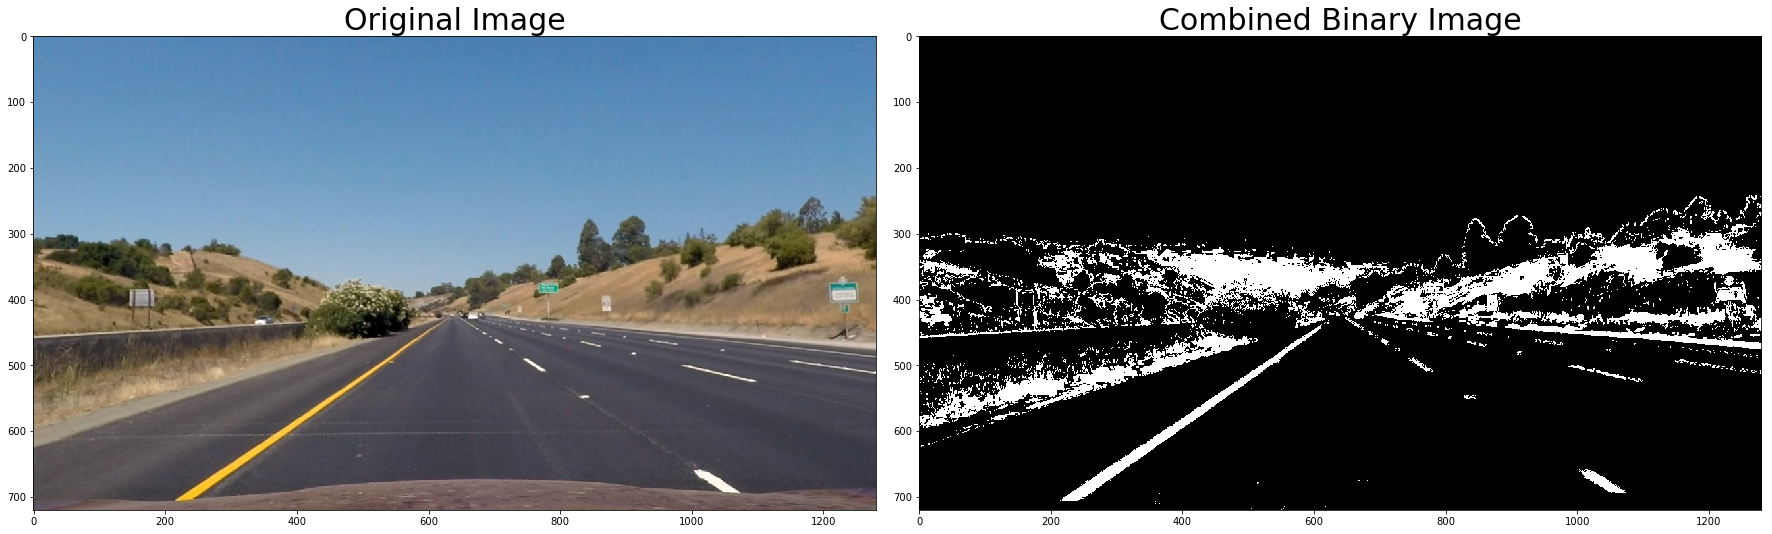

In [10]:
# Combine different options

# Combine "S" and "H" channel binaries into one hls binary
hls_binary = np.zeros_like(hls_s_binary)
hls_binary[(hls_h_binary == 1) & (hls_s_binary == 1)] = 1

# Combine this binary with the gradx binary and color binary
combined_binary = np.zeros_like(gradx)
combined_binary[((hls_binary == 1) | (gradx == 1)) & (color_thresh_binary == 1)] = 1

# Visualize combined binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Binary Image', fontsize=30)
plt.savefig('./example_images/Combined_binary.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

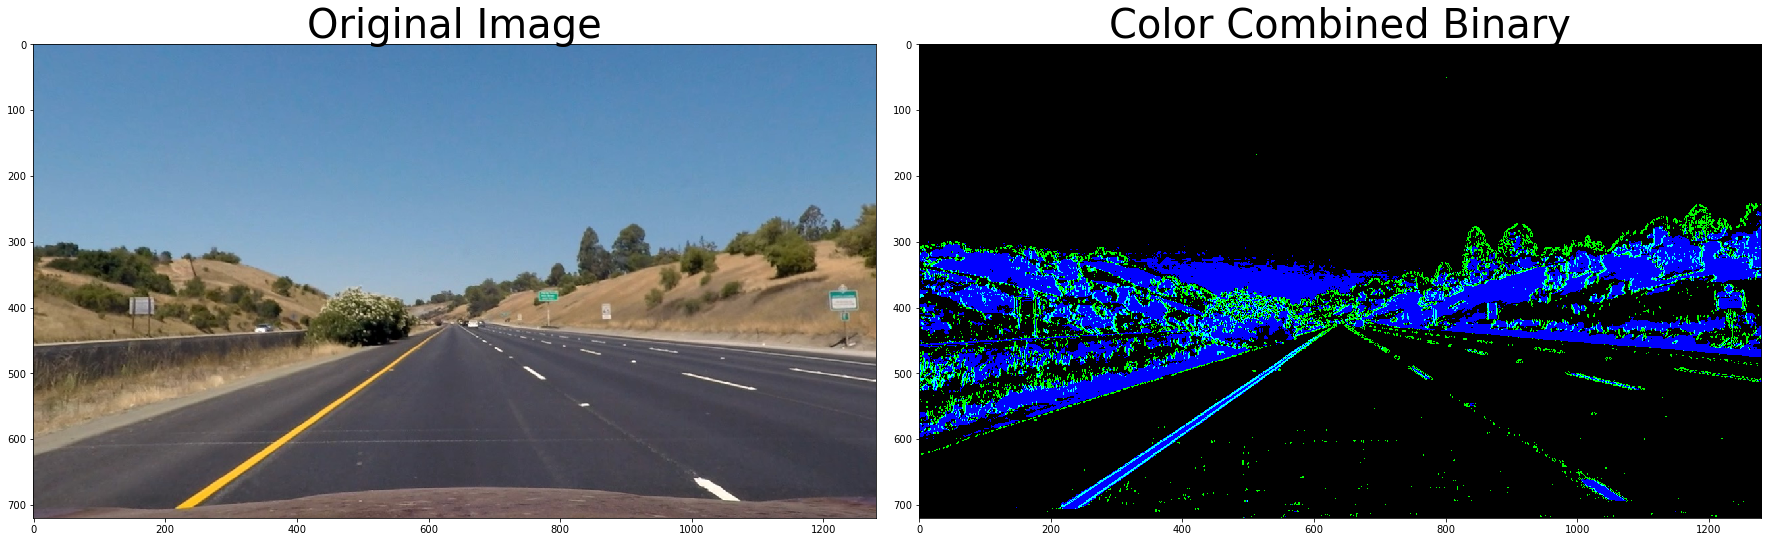

In [11]:
# Make color binary image to see the contributions of the hls and gradx
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Combined Binary', fontsize=40)
plt.savefig('./example_images/Color_combined_binary.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

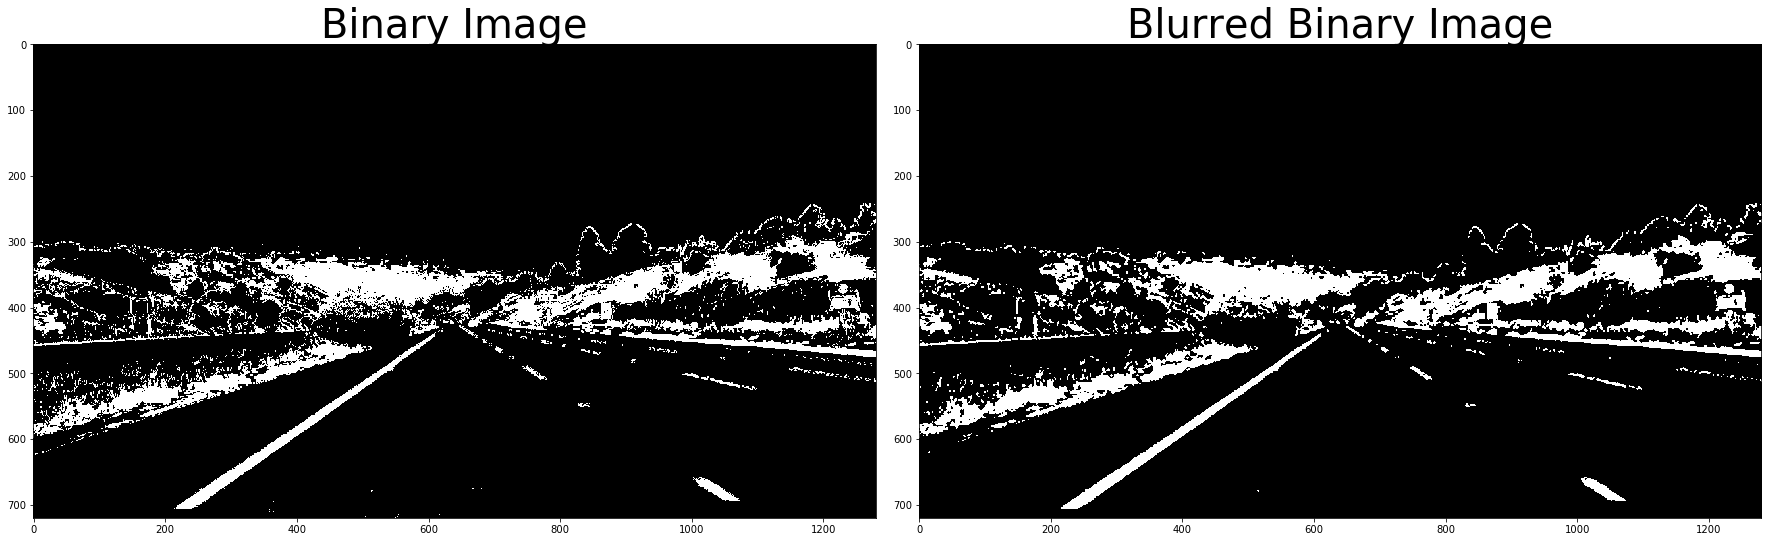

In [12]:
# Apply slight median blurr to get rid of some noise
# Higher values for ksize lead to less noise but will also reduce lane markings, especially from gradx
median = cv2.medianBlur(combined_binary,3)

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(median, cmap='gray')
ax2.set_title('Blurred Binary Image', fontsize=40)
plt.savefig('./example_images/Blurred_binary.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform to rectify binary image ("birds-eye view")

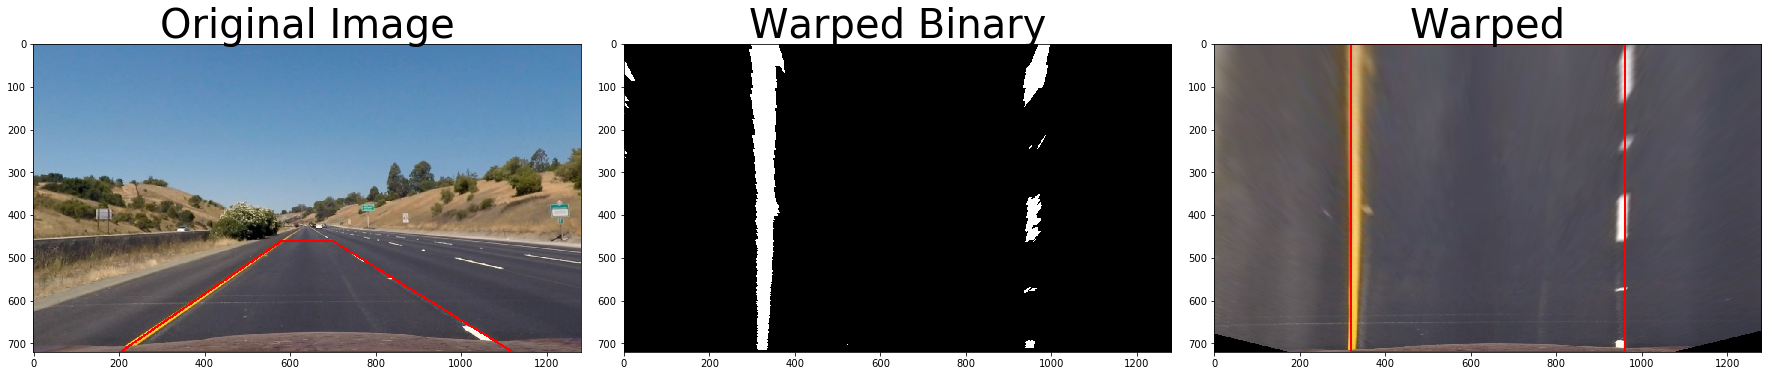

In [13]:
# Define source points
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) +55, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

# Define destination points
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Get Perspective Transform Matrix
M = cv2.getPerspectiveTransform(src, dst)

# Get Inverse Matrix to transform back later
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp image
img_size = (image.shape[1], image.shape[0])
binary_warped = cv2.warpPerspective(median, M, img_size, flags=cv2.INTER_LINEAR)
warped_col = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

# Draw source and destionation points
original_region = cv2.polylines(np.copy(image), [src.astype(np.int32)], True, (0,0,255), 3)
warped_region = cv2.polylines(warped_col, [dst.astype(np.int32)], True, (0,0,255), 3)

# Visualize
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(original_region, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=40)

ax3.imshow(cv2.cvtColor(warped_region, cv2.COLOR_BGR2RGB))
ax3.set_title('Warped', fontsize=40)
plt.savefig('./example_images/Perspective_transform.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary

In [14]:
# Take a histogram of the bottom half of the binary image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 70
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
avg_fit = (left_fit+right_fit)/2

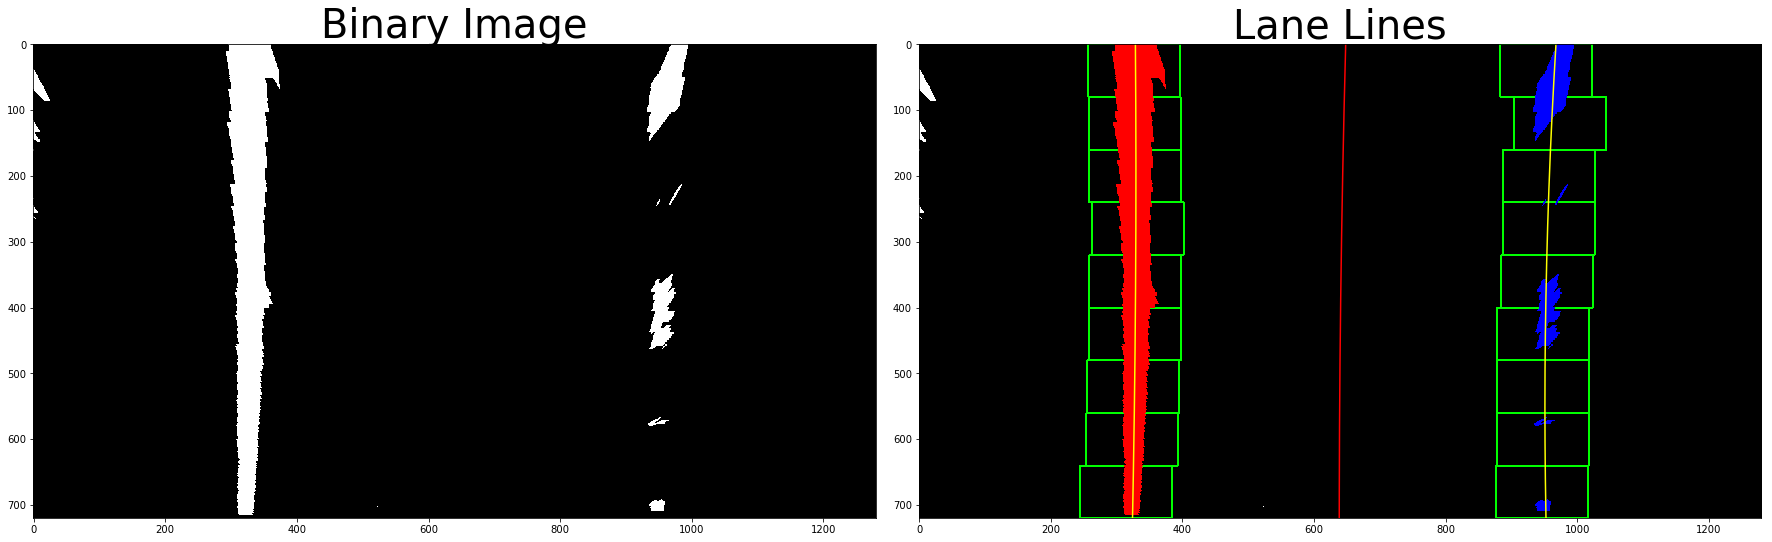

In [15]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
avg_fitx = avg_fit[0]*ploty**2 + avg_fit[1]*ploty + avg_fit[2]

# Color pixels of left and right lane
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.plot(avg_fitx, ploty, color='red')
ax2.set_title('Lane Lines', fontsize=40)

plt.savefig('./example_images/lanes.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [16]:
'''
This code can only be used if the lanes have previously been identified.
It's skipping the sliding window part.
'''

# Assuming a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 70
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
avg_fit = (left_fit+right_fit)/2
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
avg_fitx = avg_fit[0]*ploty**2 + avg_fit[1]*ploty + avg_fit[2]

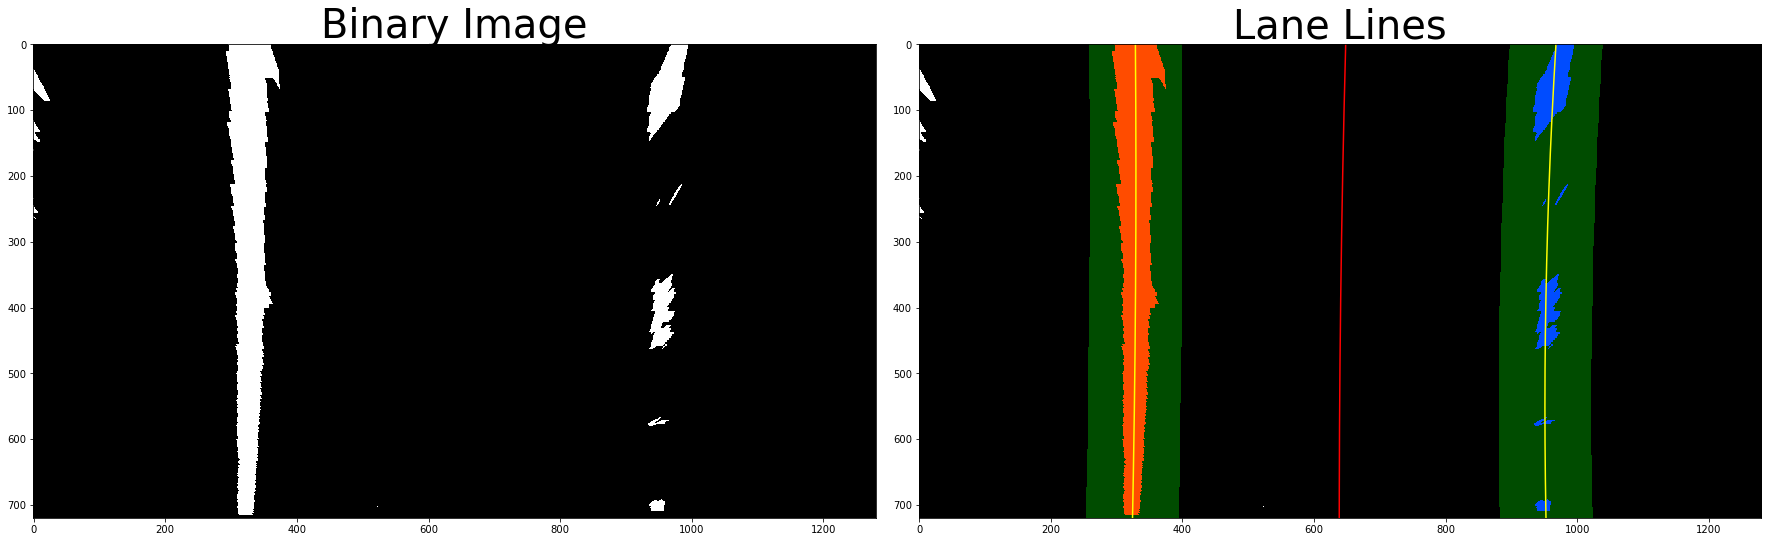

In [17]:
# Visualize

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.plot(avg_fitx, ploty, color='red')
ax2.set_title('Lane Lines', fontsize=40)

plt.savefig('./example_images/lanes_cont.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Determine the curvature of the lane and vehicle position with respect to center

In [18]:
# Get pixel curveradius value
# Define y-value where we want radius of curvature
# Maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

25835.7294401 9026.29308776


In [19]:
# Get meter curveradius value
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# Average and prepare text to go on final image
curvature_text = 'Radius of Curvature = {:.0f}m'.format((left_curverad+right_curverad)/2)
print(curvature_text)

8480.82872583 m 2963.18481629 m
Radius of Curvature = 5722m


In [20]:
# Calculate distance to center
off_center = (1280/2-((right_fitx[np.int(y_eval)]+left_fitx[np.int(y_eval)])/2))*xm_per_pix
if off_center < 0:
    print('{:.3f} meters left of center'.format(off_center*-1))
    Dis_to_center_text = 'Vehicle is {:.2f}m left of center'.format(off_center*-1)
elif off_center == 0:
    print('Dead center')
    Dis_to_center_text = 'Vehicle is dead of center'
else:
    print('{:.3f} meters right of center'.format(off_center))
    Dis_to_center_text = 'Vehicle is {:.2f}m right of center'.format(off_center)

0.010 meters right of center


## Warp the detected lane boundaries back onto the original image

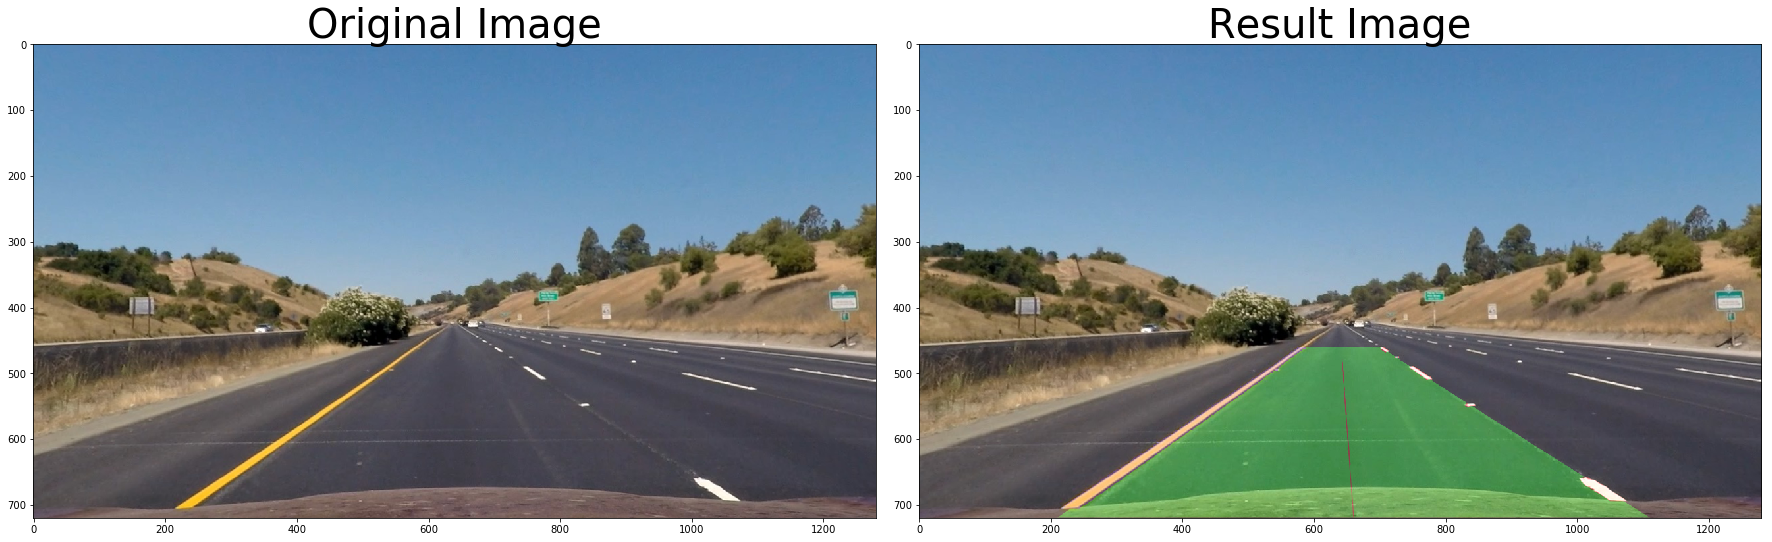

In [21]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts_avg = np.array([np.flipud(np.transpose(np.vstack([avg_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.fillPoly(color_warp, np.int_([pts_avg]), (0,0, 255))

color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax2.set_title('Result Image', fontsize=40)

plt.savefig('./example_images/lanes_result.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

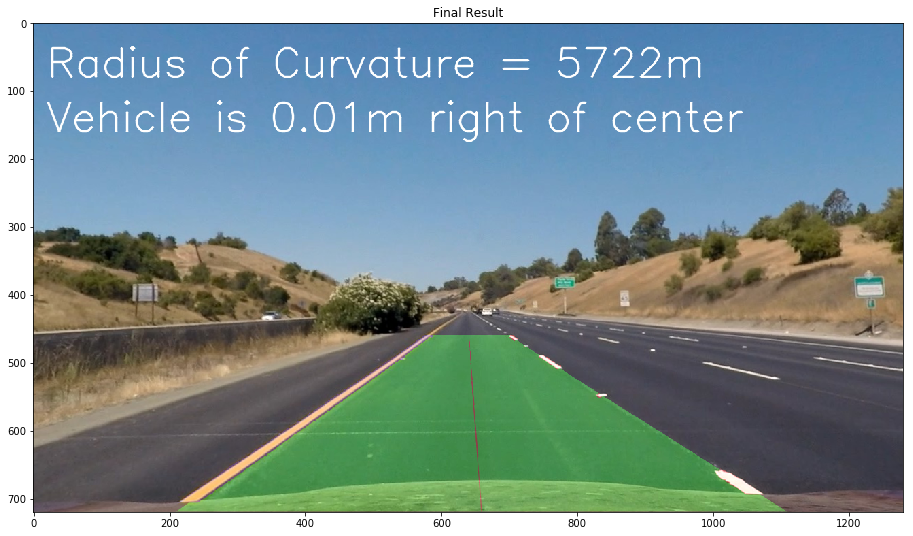

In [22]:
# Final display of image including the text
final_img = np.copy(result)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(final_img,curvature_text,(20,80), font, 2, (255,255,255), 2, cv2.LINE_AA)
cv2.putText(final_img,Dis_to_center_text,(20,160), font, 2, (255,255,255), 2, cv2.LINE_AA)

f = plt.figure(figsize = (24,9))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.title('Final Result')
plt.savefig('./example_images/final_result.png',bbox_inches='tight')
plt.show()

### END OF PART I

---

# PART II

The goals / steps of this section are the following:

* Create a pipeline reusing the code from above
* Add sanity checks
* Apply the pipeline on all test images
* Apply the pipeline on the video(s)

---

## Create a pipeline

Starting with copy of all relevant functions and imports in case notebook is run from here

In [23]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import time

# Read in pickled data for undistort
calibration_data = pickle.load(open('camera_calibration.p', 'rb'))
mtx = calibration_data['mtx']
dist = calibration_data['dist']

# Define function to undistort
def undistort_image(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Copied over functions in case it's rerun from here
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# HLS "S" channel threshold
def hls_s_threshold(img, thresh=(90,255)):
    # Get S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    S = hls[:,:,2] #L = hls[:,:,1] #H = hls[:,:,0]
    # Apply threshold
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

# HLS "H" channel threshold
def hls_h_threshold(img, thresh=(0,90)):
    # Get H channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    H = hls[:,:,0] #L = hls[:,:,1] #S = hls[:,:,2]
    # Apply threshold
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

# Color threshold
def color_threshold(img):
    # HSV transform
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Set lower and upper bounds for yellow and white
    yellow_low = np.array([0,70,80])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    # Create masks
    mask_yellow = cv2.inRange(hsv, yellow_low, yellow_high)
    mask_white = cv2.inRange(hsv, white_low, white_high)
    # Apply Gaussian Blurr
    mask_white = cv2.GaussianBlur(mask_white,(3,3),0)
    # Combine masks and make binary
    combined_color_thrsh = np.zeros_like(mask_yellow)
    combined_color_thrsh[(mask_yellow > 0) | (mask_white > 0)] = 1
    return combined_color_thrsh

# hist equalize color
def hist_equ_col(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    # Choose a Sobel kernel size
    return image

In [24]:
# Define NEW functions for the pipeline
def prepare_image(img):
    # Undistort
    undist = undistort_image(img)
    # hist_equ
    equalized_hist = hist_equ_col(undist)
    img_size = (equalized_hist.shape[1], equalized_hist.shape[0])
    # Create binary image
    gradx = abs_sobel_thresh(equalized_hist, orient='x', sobel_kernel=9, thresh=(20, 100))
    hls_s_binary = hls_s_threshold(equalized_hist)
    hls_h_binary = hls_h_threshold(equalized_hist)
    color_thresh_binary = color_threshold(equalized_hist)
    hls_binary = np.zeros_like(hls_s_binary)
    hls_binary[(hls_h_binary == 1) & (hls_s_binary == 1)] = 1
    combined_binary = np.zeros_like(gradx)
    combined_binary[((hls_binary == 1) | (gradx == 1)) & (color_thresh_binary == 1)] = 1
    median = cv2.medianBlur(combined_binary,3)
    # Warp
    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) +55, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(median, M, img_size, flags=cv2.INTER_LINEAR)
    
    return undist, M, Minv, binary_warped

def find_lanes_initial(binary_warped):
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 70
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    avg_fit = (left_fit+right_fit)/2
    
    # Fit new polynomials to x,y in world space
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr

def find_lanes_cont(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 70
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    avg_fit = (left_fit+right_fit)/2
    
    # Fit new polynomials to x,y in world space
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr

def gen_values(binary_warped, left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr):
    
    # Average for smoothing
    left_fit = np.average(left_fit,axis=0)
    right_fit = np.average(right_fit,axis=0)
    avg_fit = np.average(avg_fit,axis=0)
    left_fit_cr = np.average(left_fit_cr,axis=0)
    right_fit_cr = np.average(right_fit_cr,axis=0)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    avg_fitx = avg_fit[0]*ploty**2 + avg_fit[1]*ploty + avg_fit[2]
    
    # Curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature_text = 'Radius of Curvature = {:.0f}m'.format((left_curverad+right_curverad)/2)
    
    # Calculate distance to center
    off_center = (1280/2-((right_fitx[np.int(y_eval)]+left_fitx[np.int(y_eval)])/2))*xm_per_pix
    if off_center < 0:
        Dis_to_center_text = 'Vehicle is {:.2f}m left of center'.format(off_center*-1)
    elif off_center == 0:
        Dis_to_center_text = 'Vehicle is dead of center'
    else:
        Dis_to_center_text = 'Vehicle is {:.2f}m right of center'.format(off_center)
    
    return ploty, left_fitx, right_fitx, avg_fitx, curvature_text, Dis_to_center_text

In [25]:
# import deque to make list with automatic max # of entries for smoothing
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        #smoothing interval
        self.smootinginterval = 13
        
        #was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted_left = deque([], self.smootinginterval)
        self.recent_xfitted_right = deque([], self.smootinginterval)
        self.recent_xfitted_avg = deque([], self.smootinginterval)
        self.recent_xfitted_cur_left = deque([], self.smootinginterval)
        self.recent_xfitted_cur_right = deque([], self.smootinginterval)
        
    def pipeline(self, img):
        undist, M, Minv, binary_warped = prepare_image(img)
        
        if self.detected == True:
            try:
                left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr = find_lanes_cont(binary_warped, self.recent_xfitted_left[0], self.recent_xfitted_right[0])
                if right_fit[2]-left_fit[2]<= 0:
                    raise('!')
                if right_fit[2]-left_fit[2] > 1000:
                    raise('!')
                if (right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])-(left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2])> 1000:
                    raise('!')
                self.recent_xfitted_left.appendleft(left_fit)
                self.recent_xfitted_right.appendleft(right_fit)
                self.recent_xfitted_avg.appendleft(avg_fit)
                self.recent_xfitted_cur_left.appendleft(left_fit_cr)
                self.recent_xfitted_cur_right.appendleft(right_fit_cr)
            except:
                self.detected = False
        
        if self.detected == False:
            if len(self.recent_xfitted_left) < 10:
                try:
                    left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr = find_lanes_initial(binary_warped)
                    self.recent_xfitted_left.appendleft(left_fit)
                    self.recent_xfitted_right.appendleft(right_fit)
                    self.recent_xfitted_avg.appendleft(avg_fit)
                    self.recent_xfitted_cur_left.appendleft(left_fit_cr)
                    self.recent_xfitted_cur_right.appendleft(right_fit_cr)               
                    self.detected = True
                except:
                    self.detected = False
            else:
                try:
                    left_fit, right_fit, avg_fit, left_fit_cr, right_fit_cr = find_lanes_initial(binary_warped)
                    if right_fit[2]-left_fit[2]<= 0:
                        raise('!')
                    if right_fit[2]-left_fit[2] > 1000:
                        raise('!')
                    if (right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])-(left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2])> 1000:
                        raise('!')
                    self.recent_xfitted_left.appendleft(left_fit)
                    self.recent_xfitted_right.appendleft(right_fit)
                    self.recent_xfitted_avg.appendleft(avg_fit)
                    self.recent_xfitted_cur_left.appendleft(left_fit_cr)
                    self.recent_xfitted_cur_right.appendleft(right_fit_cr)
                    self.detected = True
                except:
                    self.detected = False
        
        # try except in case first frame is not detected
        try:
            ploty, left_fitx, right_fitx, avg_fitx, curvature_text, Dis_to_center_text = gen_values(binary_warped, self.recent_xfitted_left, self.recent_xfitted_right, self.recent_xfitted_avg, self.recent_xfitted_cur_left, self.recent_xfitted_cur_right)

            # Warp back
            warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts_avg = np.array([np.flipud(np.transpose(np.vstack([avg_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
            #Uncomment next line to show red mid_lane indicator
            #cv2.fillPoly(color_warp, np.int_([pts_avg]), (0,0, 255))
            newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
            result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
            # Final display of image including the text
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(result,curvature_text,(20,80), font, 2, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(result,Dis_to_center_text,(20,160), font, 2, (255,255,255), 2, cv2.LINE_AA)

            return result
        
        except:
            return undist

In [26]:
test_images = glob.glob('./test_images/*.jpg')
for image in test_images:
    img = cv2.imread(image)
    a = Line()
    cv2.imwrite('./output_images/'+image.split('\\')[1],a.pipeline(img))

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

linefinder = Line()
def process_image(img, linefinder=linefinder):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(linefinder.pipeline(img), cv2.COLOR_BGR2RGB)

video_out = 'output_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:57<00:00,  5.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 3min 59s


In [28]:
linefinder = Line()
challenge_video_out = 'output_challenge_video.mp4'
clip_challenge = VideoFileClip("challenge_video.mp4")
challenge_clip = clip_challenge.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_video_out, audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:21<00:00,  5.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

Wall time: 1min 23s


In [29]:
linefinder = Line()
harder_challenge_video_out = 'output_harder_challenge_video.mp4'
clip_harder = VideoFileClip("harder_challenge_video.mp4")
harder_clip = clip_harder.fl_image(process_image)
%time harder_clip.write_videofile(harder_challenge_video_out, audio=False)

[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:55<00:00,  5.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video.mp4 

Wall time: 3min 57s
